In [1]:
from pathlib import Path
import sys

# Ensure `src/` is on sys.path so we can import project modules from the notebook
repo_root = Path.cwd()
while repo_root != repo_root.parent and not (repo_root / "src").exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root))
print("Repo root set to:", repo_root)

Repo root set to: /Users/gabrielzackon/tavily-scraper/tavily-scraper


In [2]:
# Environment info (install commands kept here for reference only)
# %pip install aiohttp httpx playwright pandas numpy pyarrow matplotlib beautifulsoup4 lxml \
#               readability-lxml tldextract charset-normalizer langdetect pydantic tenacity tqdm rich python-dotenv pyyaml
# !playwright install

import sys
import platform
import pandas as pd

print("Python:", sys.version)
print("Platform:", platform.platform())

Python: 3.11.13 (main, Jun  5 2025, 08:14:07) [Clang 14.0.6 ]
Platform: macOS-10.16-x86_64-i386-64bit


In [3]:
from src.settings import DEFAULT_SCRAPE_CONFIG

DEFAULT_SCRAPE_CONFIG

ScrapeConfig(use_proxy=True, user_agent='Mozilla/5.0 (TavilyCandidateBot)', http_concurrency=20, http_total_timeout_s=20.0, http_connect_timeout_s=10.0, http_sock_read_timeout_s=15.0, browser_timeout_ms=20000, browser_headless=True, browser_block_heavy=True, max_browser_escalations=100, browser_locale='en-US', http_max_retries=1, robots_cache_path='data/robots_cache.json', robots_cache_ttl_s=86401)

In [4]:
import tldextract
from src.settings import load_proxy_from_txt

# Load proxy configuration
PROXY = load_proxy_from_txt("../data/ProxyURL.txt")
print("Proxy configured:", bool(PROXY.server))
print("Proxy (masked):", (PROXY.server[:12] + "..." + PROXY.server[-8:]) if PROXY.server else None)

# Load URL list
urls_df = (
    pd.read_csv("../data/failed_urls.csv")
      .dropna(subset=["url"])
      .drop_duplicates("url")
)

def extract_domain(url: str) -> str | None:
    try:
        return tldextract.extract(url).top_domain_under_public_suffix
    except Exception:
        return None

urls_df["domain"] = urls_df["url"].map(extract_domain)
print("Total URLs loaded:", len(urls_df))
display(urls_df.head())

Proxy configured: True
Proxy (masked): https://netw...om:65535
Total URLs loaded: 10000


,url,domain
0,https://www.crunchbase.com/person/scott-c-kay,crunchbase.com
1,https://x.com/peignoir,x.com
2,https://lawyerly.ph/digest/cc500?user=4984,lawyerly.ph
3,https://jur.ph/jurisprudence/summary/austria-v...,jur.ph
4,http://www.iea.org/countries/the-netherlands,iea.org


In [5]:
cap_per_domain = 20
target_n = 500

per_domain = urls_df.groupby("domain", group_keys=False).apply(
    lambda g: g.sample(min(len(g), cap_per_domain), random_state=42)
)

sample_df = per_domain.sample(
    n=min(target_n, len(per_domain)),
    random_state=42
).reset_index(drop=True)

print("Sample size:", len(sample_df))
display(sample_df.head())

Sample size: 500


/var/folders/jz/c2kgs0xx12ndmm7j0dymp8k80000gn/T/ipykernel_8407/4175419604.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_domain = urls_df.groupby("domain", group_keys=False).apply(


,url,domain
0,https://luatminhkhue.vn/chuyen-nhuong-quyen-su...,luatminhkhue.vn
1,https://whitestown.in.gov/whitestown-documents...,in.gov
2,https://www.resumai.com/post/ats-cv-builder,resumai.com
3,https://support.ankersolix.com/s/article/How-C...,ankersolix.com
4,https://jobs.interiorhealth.ca/ViewJobPosting/...,interiorhealth.ca


In [6]:
import aiohttp, asyncio
import tldextract
import random
from src.http_scraper import HttpScraper
from src.robots import RobotsCache
from src.metrics import FetchResult
from src.utils import robots_blocked_result, RETRYABLE_ERRORS
from src.settings import ScrapeConfig, DEFAULT_SCRAPE_CONFIG, ProxySettings

def attach_domain(fr: FetchResult) -> FetchResult:
    """Attach normalized domain to a FetchResult for grouping/analysis."""
    try:
        fr.domain = tldextract.extract(fr.url).top_domain_under_public_suffix
    except Exception:
        fr.domain = None
    return fr

async def run_http(urls: list[str], proxy_settings: ProxySettings | None = None, config: ScrapeConfig = DEFAULT_SCRAPE_CONFIG):
    """Fetch a batch of URLs using aiohttp with robots.txt checks and concurrency control."""
    timeout = aiohttp.ClientTimeout(
        total=config.http_total_timeout_s,
        connect=config.http_connect_timeout_s,
        sock_read=config.http_sock_read_timeout_s,
    )    
    connector = aiohttp.TCPConnector(limit_per_host=8, ttl_dns_cache=300)
    sem = asyncio.Semaphore(config.http_concurrency)
    results: list[FetchResult] = []

    async with aiohttp.ClientSession(timeout=timeout, connector=connector) as session:
        scraper = HttpScraper(session, config=config, proxy=proxy_settings)
        robots = RobotsCache(session, config=config)
        
        async def fetch_one(u: str):
            async with sem:
                try:
                    allowed = await robots.allowed(u)
                except Exception:
                    allowed = True
                if not allowed:
                    return robots_blocked_result(u)
                
                last_result: FetchResult | None = None
                max_retries = config.http_max_retries

                for attempt in range(max_retries + 1):
                    last_result = await scraper.fetch(u)

                    if last_result.error_type not in RETRYABLE_ERRORS:
                        last_result.retry_count = attempt
                        break

                    if attempt < max_retries:
                        await asyncio.sleep(0.1 + 0.2 * random.random())
                    else:
                        last_result.retry_count = max_retries

                last_result.proxy_hint = "proxy" if (config.use_proxy and proxy_settings is not None) else "direct"
                return last_result
            
        tasks = [asyncio.create_task(fetch_one(u)) for u in urls]
        for t in asyncio.as_completed(tasks):
            r = await t
            results.append(attach_domain(r))
    return results

http_results = await run_http(sample_df['url'].tolist(), config=DEFAULT_SCRAPE_CONFIG, proxy_settings=PROXY)
len(http_results)

500

In [7]:
from src.browser_scraper import BrowserScraper

async def run_browser(urls: list[str], proxy_settings=None, config: ScrapeConfig = DEFAULT_SCRAPE_CONFIG
):
    if not urls:
        return []

    proxy = proxy_settings if (config.use_proxy and proxy_settings is not None) else None
    results: list[FetchResult] = []

    async with BrowserScraper(config=config, proxy=proxy) as br:
        # Limit Playwright usage — avoid escalating too many URLs
        for u in urls[: config.max_browser_escalations]:
            r = await br.fetch(u, timeout_ms=config.browser_timeout_ms)
            r.proxy_hint = "proxy" if (config.use_proxy and proxy_settings is not None) else "direct"
            results.append(r)

    return results


In [8]:
from dataclasses import asdict

def to_df(results) -> pd.DataFrame:
    return pd.DataFrame([asdict(r) for r in results]) if results else pd.DataFrame()


In [9]:
def classify_failure(row):
    if row['error_type'] == "robots_blocked":
        return "robots_blocked"
    if row['captcha']:
        return "captcha"
    if pd.notna(row['status']) and row['status'] >= 400:
        return f"http_{int(row['status'])}"
    if pd.isna(row['status']) and row['error_type']:
        return "transport_error"
    return "ok"


In [10]:
# Build DataFrame from results
df_http = to_df(http_results)

# Add a clear failure bucket column
df_http["failure_reason"] = df_http.apply(classify_failure, axis=1)

avg_retries = df_http["retry_count"].mean()
max_retries = df_http["retry_count"].max()

print(f"Average HTTP retries per URL: {avg_retries:.3f}")
print("Max retries for any URL:", max_retries)

print("\nRetry distribution:")
display(df_http["retry_count"].value_counts().sort_index())

# Sanity checks
display(df_http[['url','domain','status','bytes_len','error_type','captcha','failure_reason']].head(10))

df_http['failure_reason'].value_counts()

Average HTTP retries per URL: 0.090
Max retries for any URL: 1

Retry distribution:


retry_count
0    455
1     45
Name: count, dtype: int64

,url,domain,status,bytes_len,error_type,captcha,failure_reason
0,https://npidb.org/organizations/ambulatory_hea...,npidb.org,403.0,9732,None,False,http_403
1,https://www.muskoka.on.ca/en/careers-and-volun...,muskoka.on.ca,NaN,0,ClientConnectorSSLError,False,transport_error
2,https://www.ajconline.org/article/S0002-9149(2...,ajconline.org,403.0,9545,None,False,http_403
3,https://www.linux.org/threads/virtualbox-for-l...,linux.org,403.0,9486,None,False,http_403
4,https://luatminhkhue.vn/tom-tat-cuoc-gap-go-ti...,luatminhkhue.vn,403.0,9498,None,False,http_403
5,https://www.resumai.com/post/ats-cv-builder,resumai.com,200.0,47712,None,False,ok
6,https://rri.co.id/nasional/1868766/begini-nask...,rri.co.id,403.0,9639,None,False,http_403
7,https://luatminhkhue.vn/chuyen-nhuong-quyen-su...,luatminhkhue.vn,403.0,9637,None,False,http_403
8,https://www.barrons.com/market-data/stocks/bneff,barrons.com,401.0,773,None,True,captcha
9,https://whitestown.in.gov/whitestown-documents...,in.gov,200.0,114929,None,False,ok


failure_reason
ok                 196
http_403           125
captcha             84
transport_error     43
robots_blocked      20
http_404            16
http_429             7
http_500             3
http_406             2
http_502             1
http_503             1
http_401             1
http_522             1
Name: count, dtype: int64

In [11]:
transport = df_http[df_http["failure_reason"] == "transport_error"]

print("Transport errors:", len(transport), "out of", len(df_http))
display(
    transport["error_type"]
    .value_counts()
    .rename_axis("error_type")
    .reset_index(name="count")
)

Transport errors: 43 out of 500


,error_type,count
0,ClientHttpProxyError,14
1,TimeoutError,12
2,ClientConnectorCertificateError,7
3,ClientPayloadError,3
4,ClientConnectorError,3
5,ClientConnectorSSLError,2
6,ClientResponseError,1
7,ServerDisconnectedError,1


In [12]:
transport_domain = (
    transport.groupby("domain")["url"]
    .count()
    .sort_values(ascending=False)
    .head(10)
    .rename("count")
    .reset_index()
)

print("Top domains by transport errors:")
display(transport_domain)

Top domains by transport errors:


,domain,count
0,uinjkt.ac.id,3
1,dnb.com,2
2,iitd.ac.in,2
3,moi.gov.mm,2
4,stone.edu,2
5,loopnet.ca,2
6,17plus1-thinktank.cn,1
7,canarabank.bank.in,1
8,danang.gov.vn,1
9,helloratio.ca,1


In [13]:
from src.policy import should_escalate

need_browser_mask = df_http.apply(
    lambda row: should_escalate(type("R",(object,), row.to_dict())()),
    axis=1,
)

to_browser = df_http[need_browser_mask]["url"].head(100).tolist()

browser_results = await run_browser(
    to_browser,
    proxy_settings=PROXY,
    config=DEFAULT_SCRAPE_CONFIG,
)

df_browser = to_df(browser_results)
df_browser["failure_reason"] = df_browser.apply(classify_failure, axis=1)

print("Escalated URLs:", len(to_browser), " | Browser results:", len(df_browser))
display(df_browser.head())
df_browser["failure_reason"].value_counts()

Escalated URLs: 100  | Browser results: 100


,url,scraper,bytes_len,captcha,ttl_s,ttfb_s,error_type,status,domain,proxy_hint,retry_count,failure_reason
0,https://npidb.org/organizations/ambulatory_hea...,browser,18748,False,2.269422,2.252941,None,403.0,None,proxy,0,http_403
1,https://www.muskoka.on.ca/en/careers-and-volun...,browser,0,False,1.629012,NaN,Error,NaN,None,proxy,0,transport_error
2,https://www.ajconline.org/article/S0002-9149(2...,browser,8198,False,1.297888,1.287558,None,403.0,None,proxy,0,http_403
3,https://www.linux.org/threads/virtualbox-for-l...,browser,7293,False,0.951386,0.940765,None,403.0,None,proxy,0,http_403
4,https://luatminhkhue.vn/tom-tat-cuoc-gap-go-ti...,browser,7894,False,1.290632,1.279474,None,403.0,None,proxy,0,http_403


failure_reason
http_403           56
transport_error    17
ok                  8
http_404            6
captcha             5
http_429            3
http_500            2
http_502            1
http_406            1
http_503            1
Name: count, dtype: int64

In [14]:
# Mark source for merging
df_http_ = df_http.assign(source="http")
df_browser_ = df_browser.assign(source="browser")

combined = pd.concat([df_http_, df_browser_], ignore_index=True, sort=False)

# Success flag
combined["ok"] = (
    combined["error_type"].isna()
    & ~combined["captcha"]
    & (combined["status"].fillna(0) < 400)
)

# Pick "best" row per URL (prefer ok; then larger bytes)
best_idx = (
    combined
    .sort_values(["ok", "bytes_len"], ascending=[True, False])
    .groupby("url", as_index=False)
    .head(1)
    .index
)

hybrid = combined.loc[best_idx].copy()
hybrid["policy"] = "hybrid_best_of"
hybrid["failure_reason"] = hybrid.apply(classify_failure, axis=1)

http_only = df_http.copy()
http_only["policy"] = "http_only"

browser_only = df_browser.copy()
browser_only["policy"] = "browser_only"

def summarize(df: pd.DataFrame, name: str) -> pd.Series:
    """Compute basic metrics for a given scraping policy."""
    success_mask = (
        df["error_type"].isna()
        & ~df["captcha"]
        & (df["status"].fillna(0) < 400)
    )
    return pd.Series({
        "policy": name,
        "n": len(df),
        "success_rate": success_mask.mean(),
        "avg_ttl_s": df["ttl_s"].mean(),
        "p50_bytes": df["bytes_len"].median(),
        "p90_bytes": df["bytes_len"].quantile(0.90),
        "avg_retries": df["retry_count"].mean(),
        "max_retries": df["retry_count"].max,
    })

summary = pd.concat([
    summarize(http_only, "http_only"),
    summarize(browser_only, "browser_only"),
    summarize(hybrid, "hybrid_best_of"),
], axis=1).T

display(summary)

,policy,n,success_rate,avg_ttl_s,p50_bytes,p90_bytes,avg_retries,max_retries
0,http_only,500,0.392,3.101982,9498.0,494599.9,0.09,<bound method Series.max of 0 0\n1 0...
1,browser_only,100,0.08,3.512263,7636.5,49037.9,0.0,<bound method Series.max of 0 0\n1 0\n...
2,hybrid_best_of,500,0.39,3.165654,9502.5,494599.9,0.09,<bound method Series.max of 189 0\n424 0...


In [15]:
import numpy as np

# --- Cost model assumptions (tweakable) ---
HTTP_UNIT_COST = 1.0
BROWSER_UNIT_COST = 8.0

# Rough counts of calls actually made in this run
n_http_calls = len(df_http)
n_browser_calls = len(df_browser)
n_hybrid_urls = len(hybrid)

print("HTTP calls:", n_http_calls, "| Browser calls:", n_browser_calls, "| Hybrid URLs:", n_hybrid_urls)

summary_cost = summary.copy()

# Initialize columns
summary_cost["http_calls"] = 0
summary_cost["browser_calls"] = 0

# HTTP-only: only HTTP
summary_cost.loc[summary_cost["policy"] == "http_only", "http_calls"] = n_http_calls
summary_cost.loc[summary_cost["policy"] == "http_only", "browser_calls"] = 0

# Browser-only: only Browser
summary_cost.loc[summary_cost["policy"] == "browser_only", "http_calls"] = 0
summary_cost.loc[summary_cost["policy"] == "browser_only", "browser_calls"] = n_browser_calls

# Hybrid: HTTP for all + Browser for escalated subset
summary_cost.loc[summary_cost["policy"] == "hybrid_best_of", "http_calls"] = n_http_calls
summary_cost.loc[summary_cost["policy"] == "hybrid_best_of", "browser_calls"] = n_browser_calls

# Compute total cost
summary_cost["total_cost_units"] = (
    summary_cost["http_calls"] * HTTP_UNIT_COST
    + summary_cost["browser_calls"] * BROWSER_UNIT_COST
)

# Estimated number of successes
summary_cost["successes"] = summary_cost["n"] * summary_cost["success_rate"]

# Cost per successful page
summary_cost["cost_per_success"] = summary_cost["total_cost_units"] / summary_cost["successes"].replace(0, np.nan)

display(summary_cost)


HTTP calls: 500 | Browser calls: 100 | Hybrid URLs: 500


,policy,n,success_rate,avg_ttl_s,p50_bytes,p90_bytes,avg_retries,max_retries,http_calls,browser_calls,total_cost_units,successes,cost_per_success
0,http_only,500,0.392,3.101982,9498.0,494599.9,0.09,<bound method Series.max of 0 0\n1 0...,500,0,500.0,196.0,2.55102
1,browser_only,100,0.08,3.512263,7636.5,49037.9,0.0,<bound method Series.max of 0 0\n1 0\n...,0,100,800.0,8.0,100.0
2,hybrid_best_of,500,0.39,3.165654,9502.5,494599.9,0.09,<bound method Series.max of 189 0\n424 0...,500,100,1300.0,195.0,6.666667


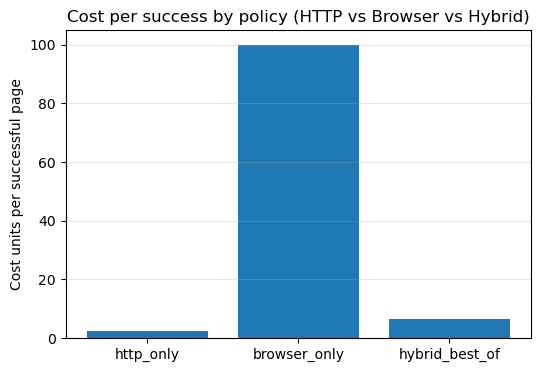

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(summary_cost["policy"], summary_cost["cost_per_success"])
plt.ylabel("Cost units per successful page")
plt.title("Cost per success by policy (HTTP vs Browser vs Hybrid)")
plt.grid(axis="y", alpha=0.3)
plt.show()


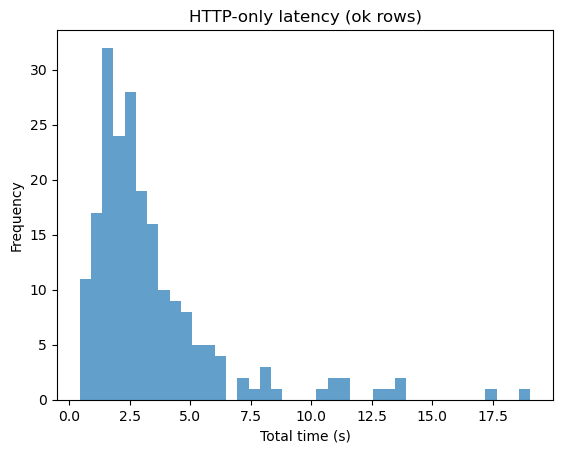

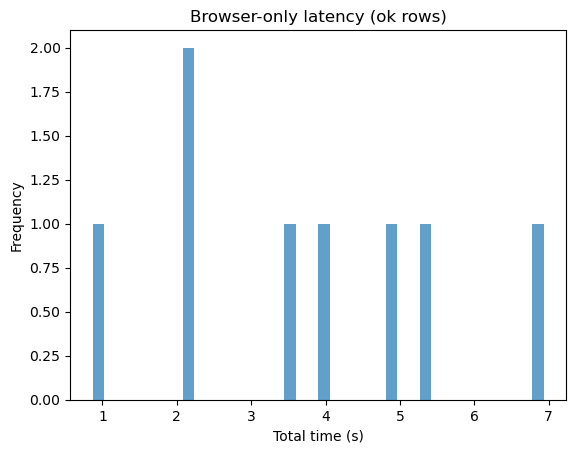

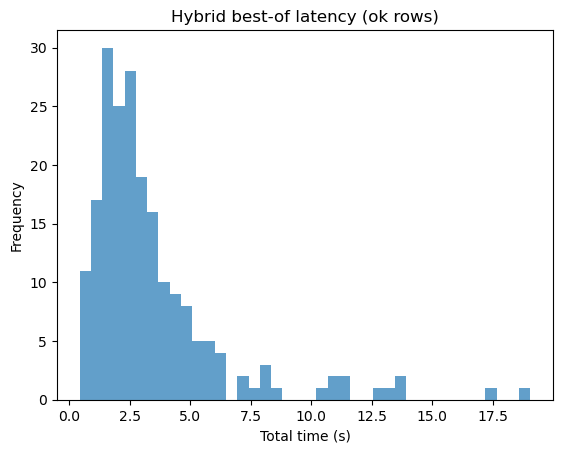

<Figure size 640x480 with 0 Axes>

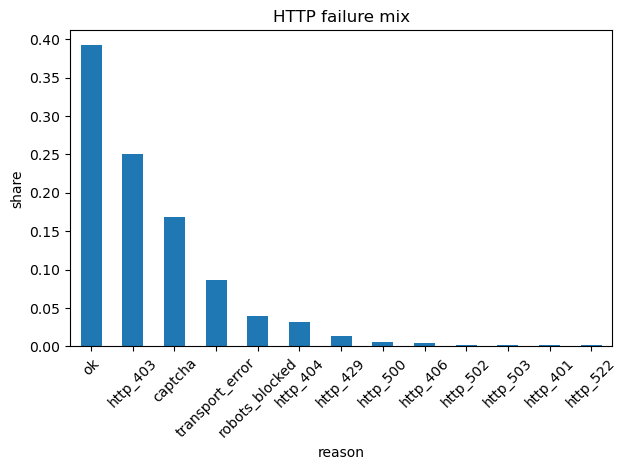

<Figure size 640x480 with 0 Axes>

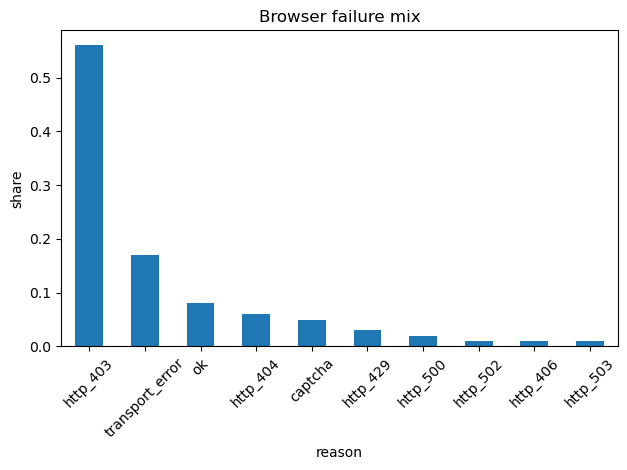

<Figure size 640x480 with 0 Axes>

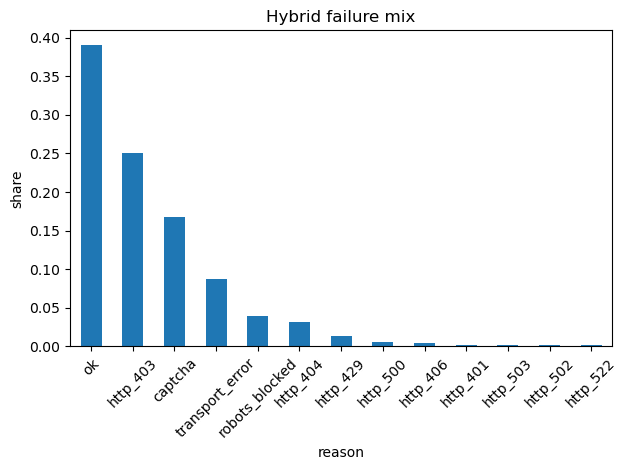

In [17]:
import matplotlib.pyplot as plt

def hist_latency(df, title):
    ok = df[(df["error_type"].isna()) & (df["status"].fillna(0) < 400)]
    if ok.empty:
        print(f"No successful rows for {title}")
        return
    plt.figure()
    ok["ttl_s"].plot(kind="hist", bins=40, alpha=0.7)
    plt.xlabel("Total time (s)"); plt.title(title); plt.show()

hist_latency(http_only, "HTTP-only latency (ok rows)")
hist_latency(browser_only, "Browser-only latency (ok rows)")
hist_latency(hybrid, "Hybrid best-of latency (ok rows)")

# Failure mix bar chart, using existing failure_reason column
for name, df in [("HTTP", http_only), ("Browser", browser_only), ("Hybrid", hybrid)]:
    if "failure_reason" not in df.columns:
        # if hybrid doesn't have it yet, you can skip or recompute later
        print(f"{name}: no failure_reason column")
        continue
    fr = (
        df["failure_reason"]
        .value_counts(normalize=True)
        .rename_axis("reason")
        .reset_index(name="share")
    )
    plt.figure()
    fr.plot(x="reason", y="share", kind="bar", legend=False, rot=45)
    plt.title(f"{name} failure mix"); plt.ylabel("share"); plt.tight_layout(); plt.show()


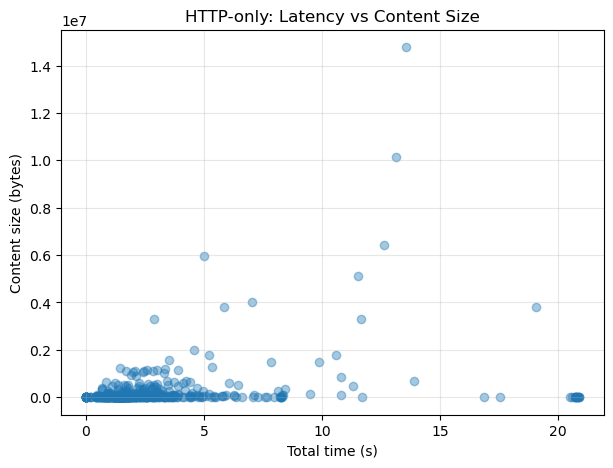

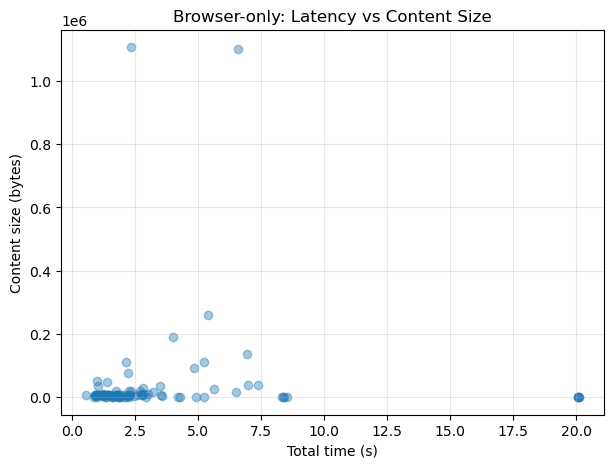

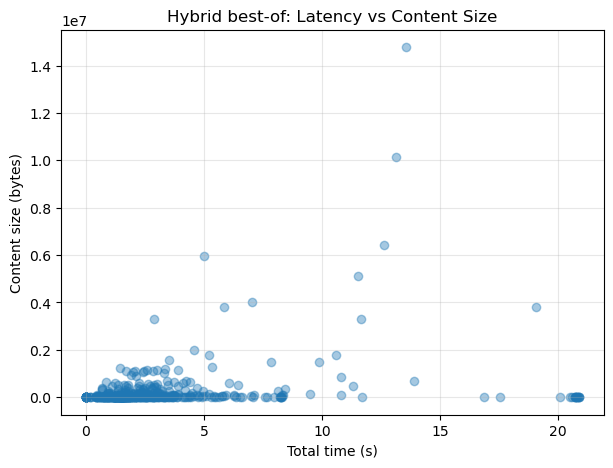

In [18]:
import matplotlib.pyplot as plt

def scatter_latency_size(df, title):
    if df.empty:
        print(f"No data for {title}")
        return
    plt.figure(figsize=(7,5))
    plt.scatter(df["ttl_s"], df["bytes_len"], alpha=0.4)
    plt.xlabel("Total time (s)")
    plt.ylabel("Content size (bytes)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

scatter_latency_size(http_only,   "HTTP-only: Latency vs Content Size")
scatter_latency_size(browser_only,"Browser-only: Latency vs Content Size")
scatter_latency_size(hybrid,      "Hybrid best-of: Latency vs Content Size")


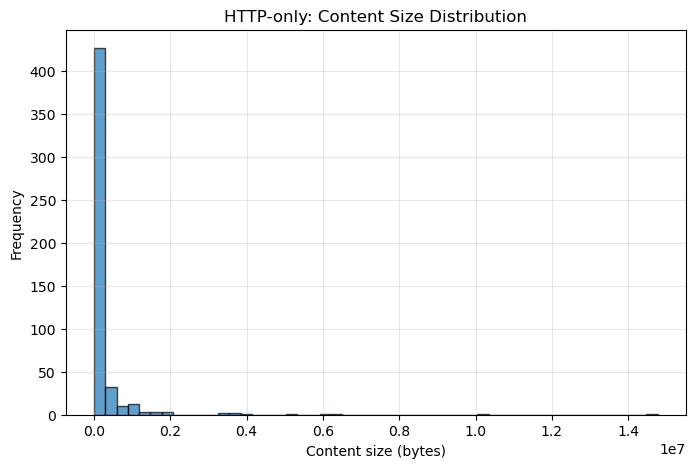

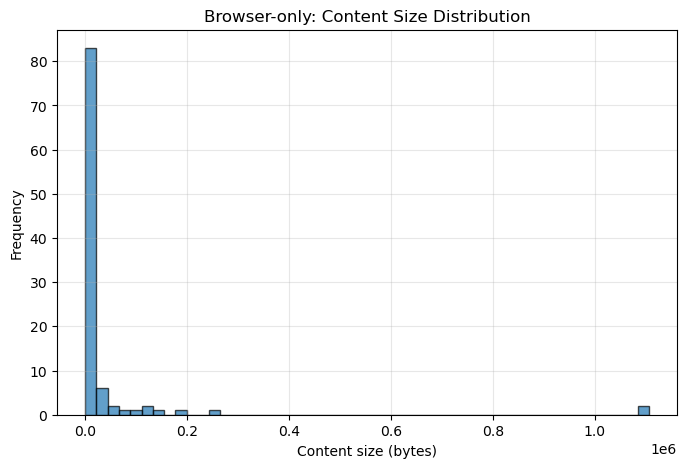

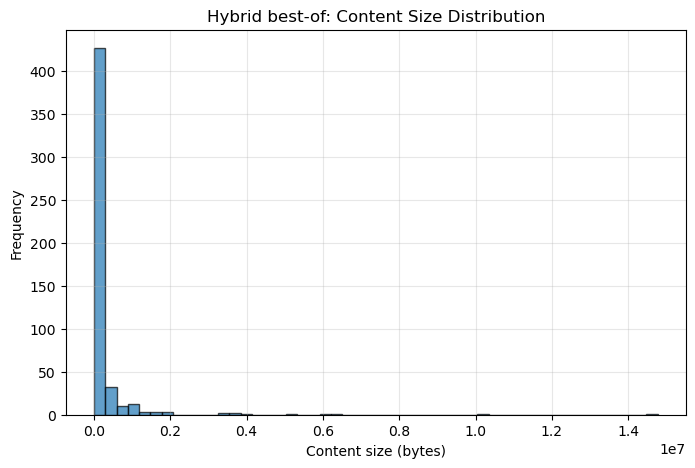

In [19]:
def hist_bytes(df, title):
    if df.empty:
        print(f"No data for {title}")
        return
    plt.figure(figsize=(8,5))
    df["bytes_len"].plot(kind="hist", bins=50, alpha=0.7, edgecolor="black")
    plt.xlabel("Content size (bytes)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

hist_bytes(http_only,   "HTTP-only: Content Size Distribution")
hist_bytes(browser_only,"Browser-only: Content Size Distribution")
hist_bytes(hybrid,      "Hybrid best-of: Content Size Distribution")


In [20]:
from src.storage import save_df

# Save detailed per-URL results
save_df(df_http,    "http_results")
save_df(df_browser, "browser_results")
save_df(hybrid,     "hybrid_best_of")

# Save policy-level summary
save_df(summary_cost, "policy_summary_with_cost")

Saved results/http_results.csv
Saved results/browser_results.csv
Saved results/hybrid_best_of.csv
Saved results/policy_summary_with_cost.csv
